In [91]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [92]:
# Parameters of the problem
# The model that will be used is y(x) = s1 + ln(1 + exp((s2 - s1) + s3 * x))
# The data will be generated with a (decreasing) line followed by a constant value (modeloffset)
linerate = -2             # An artificial model y = linerate * x + modeloffset is used to generate data
modeloffset = 53          # See here above
noiselevel = 2            # standard deviation of the noise applied to the observed values
XMIN = -10                # Minimum value for input value
XMAX = 40                 # Maximum value for input value
YMIN = 7                  # Minimum observed value
YMAX = 80                 # Maximum observed value
N = XMAX - XMIN + 1       # Number of samples
seedinit = 1              # Initialization value for random generation
alpha = 0.05              # Multiplier for the gradient algorithm
NLOOPS = 10000             # Number of iterations for the optimization algorithm
NVIEWS = 20               # Number of printed lines during optimization (for debugging)

In [93]:
xin = np.arange(XMIN,XMAX+1,1,dtype=float).reshape(N, 1) # Generating the input values
Ain = np.concatenate((np.ones((N,1),dtype=float), xin), axis=1) # Building the matrix: A x = y for the expected values
np.random.seed(seedinit) # Initializing the generator the control the reproducibility of the test
yin = linerate * xin + modeloffset # Generating observed values
yin = np.where(yin < YMIN, YMIN, yin) + noiselevel * (np.random.randn(N,1) - 0.5)

In [94]:
x = tf.placeholder(tf.float32, shape=(N,1)) # Placeholder for the inputs
y = tf.placeholder(tf.float32, shape=(N,1)) # Placeholder for the observed values
#s = tf.Variable([[YMIN],[modeloffset],[linerate]], dtype=tf.float32) # Case with squared_difference 
                                                                      # (converges only with good initial values)
s = tf.Variable(tf.zeros([3, 1]), dtype=tf.float32) # Works (with a lot of iterations and alpha = 0.05 for median estimation)
ys = s[0][0] + tf.log(1 + tf.exp((s[1][0] - s[0][0]) + s[2][0] * x))
#cost_function = tf.reduce_mean(tf.squared_difference(ys, y)) # OK with good initial values and alpha = 0.01
cost_function = tf.reduce_mean(tf.abs(ys - y)) # Absolute values <=> median estimation
train_step = tf.train.GradientDescentOptimizer(alpha).minimize(cost_function)

In [95]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
np.set_printoptions(precision=3, suppress=True)
for i in range(NLOOPS+1):
    sess.run(train_step, feed_dict = {x:xin, y:yin})
    sout, ysout, costout = sess.run([s, ys, cost_function], feed_dict = {x:xin, y:yin})
    if (NVIEWS > 0) and ((i % int(NLOOPS/NVIEWS)) == 0):
        print("step: " + str(i) + ", cost:" + str(costout) + ", s:" + str(sout.reshape(3)))
    #print(ysout)

step: 0, cost:25.803238, s:[0.025 0.025 0.375]
step: 500, cost:14.111216, s:[ 7.977  5.737 -7.755]
step: 1000, cost:13.665284, s:[10.246  7.694 -8.023]
step: 1500, cost:13.508095, s:[10.615  9.617 -7.743]
step: 2000, cost:13.328767, s:[10.616 11.712 -7.437]
step: 2500, cost:13.115754, s:[10.617 13.996 -7.113]
step: 3000, cost:12.8832855, s:[10.569 16.383 -6.783]
step: 3500, cost:12.584779, s:[10.259 19.064 -6.397]
step: 4000, cost:12.223967, s:[10.2   22.03  -5.964]
step: 4500, cost:11.727214, s:[10.161 25.457 -5.199]
step: 5000, cost:10.986544, s:[ 9.636 29.681 -4.664]
step: 5500, cost:9.740974, s:[ 9.319 35.178 -3.989]
step: 6000, cost:4.7614665, s:[ 8.415 43.637 -1.557]
step: 6500, cost:1.6710263, s:[ 6.239 51.37  -1.905]
step: 7000, cost:1.5409365, s:[ 6.239 51.431 -1.972]
step: 7500, cost:1.540931, s:[ 6.239 51.431 -1.972]
step: 8000, cost:1.5409659, s:[ 6.238 51.431 -1.972]
step: 8500, cost:1.5409598, s:[ 6.238 51.431 -1.972]
step: 9000, cost:1.540939, s:[ 6.24  51.431 -1.972]
st

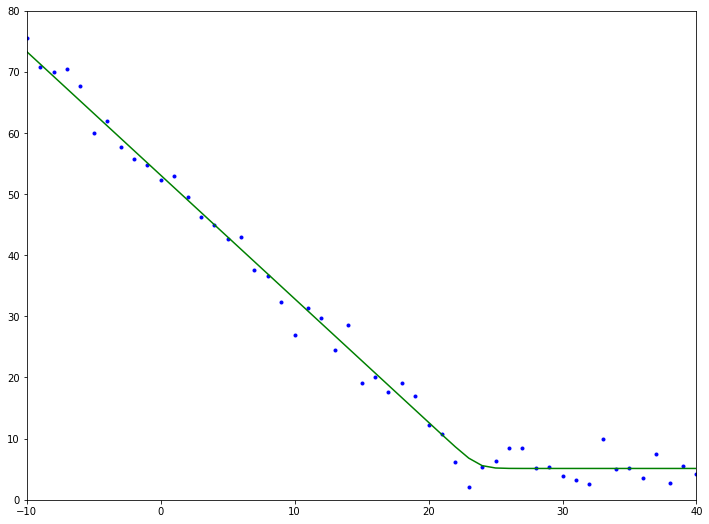

In [90]:
plt.figure(figsize=(12,9))
plt.axis([XMIN, XMAX, 0, YMAX])
plt.plot(xin, yin, 'b.')        # Displaying the samples used for fitting
plt.plot(xin, ysout, 'g')